In [0]:
# from google.colab import files
# uploaded = files.upload()

In [0]:
from pandas import DataFrame
import pandas

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [65]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

n_step = 3

dataset = read_csv('pm2.5.csv', header=0, index_col=0)
#print(dataset)
dataset = series_to_supervised(dataset, n_step, 1)
values = dataset.values
#print(values)


n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print(train.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 3))
test_X = test_X.reshape((test_X.shape[0], 3))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 4)
(35040, 3) (35040,) (8756, 3) (8756,)


In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Network
model = Sequential()
train

model.add(Dense(100, activation='relu', input_dim=n_step))
#model.add(LSTM(100, input_shape=(train_X.shape[1], 1)))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35040 samples, validate on 8756 samples
Epoch 1/50
 - 1s - loss: 0.0171 - val_loss: 0.0125
Epoch 2/50
 - 1s - loss: 0.0137 - val_loss: 0.0121
Epoch 3/50
 - 1s - loss: 0.0136 - val_loss: 0.0120
Epoch 4/50
 - 1s - loss: 0.0135 - val_loss: 0.0120
Epoch 5/50
 - 1s - loss: 0.0136 - val_loss: 0.0120
Epoch 6/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 7/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 8/50
 - 1s - loss: 0.0135 - val_loss: 0.0119
Epoch 9/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 10/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 11/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 12/50
 - 1s - loss: 0.0133 - val_loss: 0.0120
Epoch 13/50
 - 1s - loss: 0.0133 - val_loss: 0.0120
Epoch 14/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 15/50
 - 1s - loss: 0.0133 - val_loss: 0.0120
Epoch 16/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 17/50
 - 1s - loss: 0.0134 - val_loss: 0.0120
Epoch 18/50
 - 1s - loss: 0.0133 - val_loss: 0.0120
Epoch 19/50
 - 1s - loss

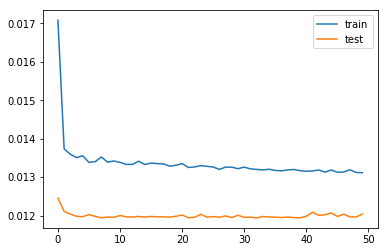

In [67]:
# plot history
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [68]:
from math import sqrt
from numpy import concatenate
#from numpy import scaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# make a prediction
print(test_X.shape)
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
scaler = StandardScaler()
scaler.fit(test_X)
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)

# print(test_y)
# print(yhat)

(8756, 3)
0.002249883536118255


In [69]:
yhat = model.predict(test_X)
# print(test_y)
# print(yhat)

rms = sqrt(mean_squared_error(yhat, test_y))
print(rms)

0.023900331771215304
